<a href="https://colab.research.google.com/github/vaishnavvk/Machine-Learning-Code/blob/main/Cats_vs_Dogs_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow_hub as hub

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68606236/68606236 [==============================] - 2s 0us/step


In [8]:
zip_dir_base = os.path.dirname(zip_dir)

In [9]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
val_cats_dir = os.path.join(val_dir, 'cats')
val_dogs_dir = os.path.join(val_dir, 'dogs')

In [10]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(val_cats_dir))
num_dogs_val = len(os.listdir(val_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [11]:
BATCH_SIZE = 100
IMG_SHAPE = 224

In [12]:
train_image_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [13]:
val_image_generator = ImageDataGenerator(rescale=1./255)
val_data_gen = val_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=val_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary')

Found 1000 images belonging to 2 classes.


In [14]:
URL_ = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL_, 
                                   input_shape = (IMG_SHAPE,IMG_SHAPE,3))

In [15]:
feature_extractor.trainable = False

In [25]:
model = Sequential([
    feature_extractor,
    Dropout(0.2),
    Dense(2)
])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [28]:
EPOCHS = 3
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/3
20/20 [==============================] - 34s 2s/step - loss: 0.3640 - accuracy: 0.8335 - val_loss: 0.1115 - val_accuracy: 0.9680
Epoch 2/3
20/20 [==============================] - 32s 2s/step - loss: 0.1400 - accuracy: 0.9530 - val_loss: 0.0706 - val_accuracy: 0.9750
Epoch 3/3
20/20 [==============================] - 31s 2s/step - loss: 0.1307 - accuracy: 0.9530 - val_loss: 0.0598 - val_accuracy: 0.9790


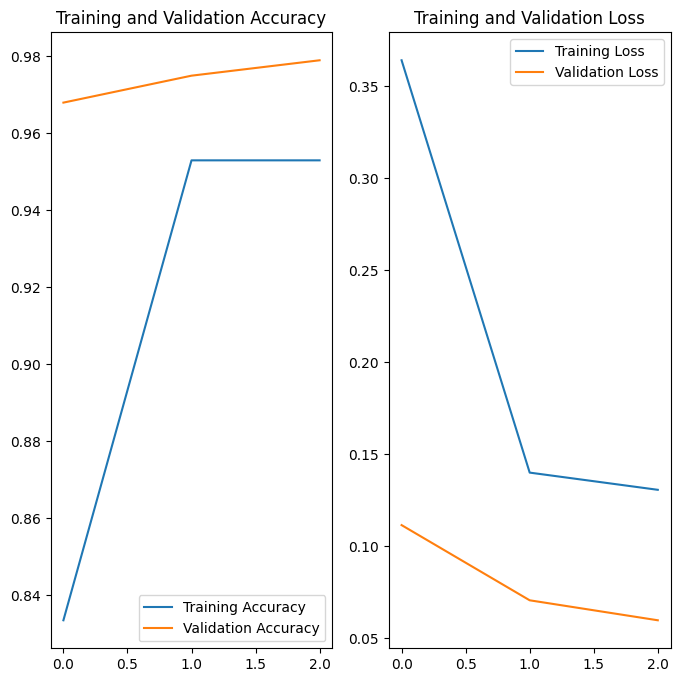

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [39]:
class_names = np.array(['cat', 'dog'])
class_names

array(['cat', 'dog'], dtype='<U3')

In [63]:
sample_training_images, label_batch = next(train_data_gen)
prediction = model.predict(sample_training_images)
prediction = tf.squeeze(prediction).numpy()
prediction_ids = np.argmax(prediction, axis=-1)
prediction_class = class_names[prediction_ids]
prediction_class

4/4 [==============================] - 0s 43ms/step


array(['dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog',
       'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog',
       'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat',
       'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog',
       'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat',
       'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat',
       'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat',
       'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat',
       'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat',
       'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog',
       'dog'], dtype='<U3')

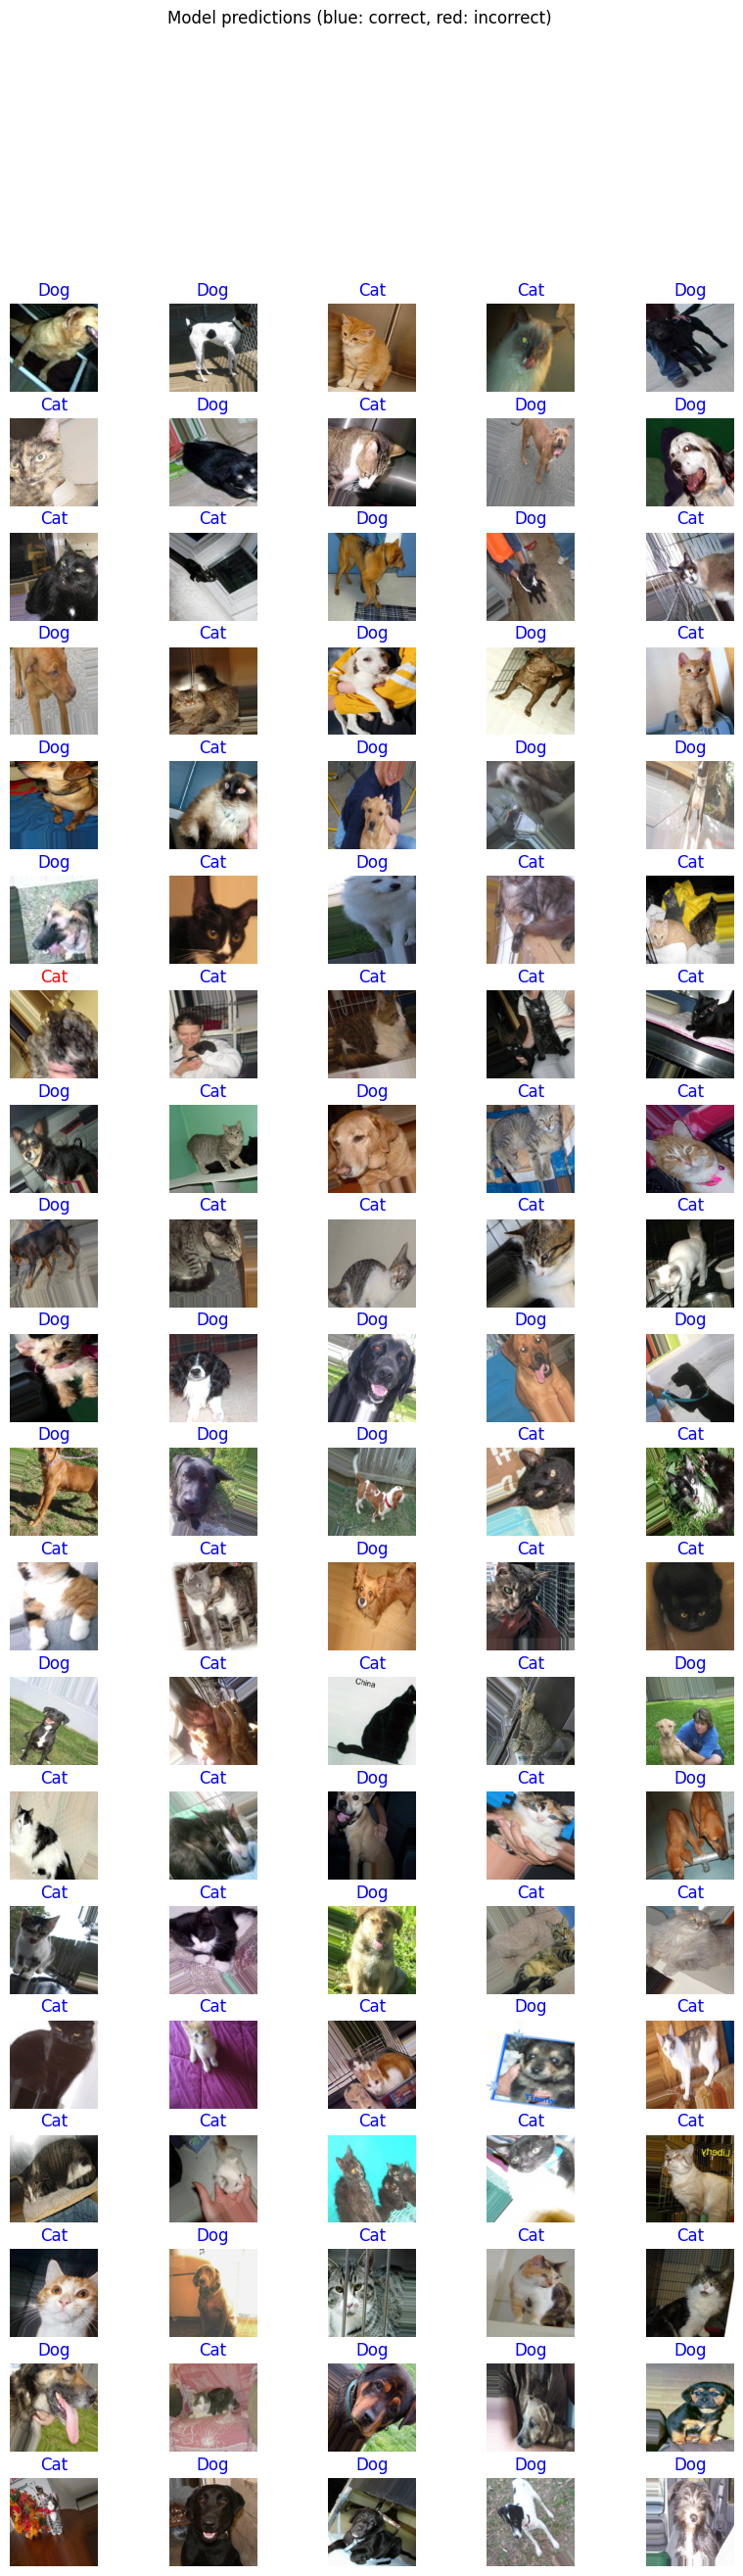

In [64]:
plt.figure(figsize=(10,30))
for n in range(100):
  plt.subplot(20,5,n+1)
  plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
  plt.imshow(sample_training_images[n])
  color = "blue" if prediction_ids[n] == label_batch[n] else "red"
  plt.title(prediction_class[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

1/1 [==============================] - 0s 34ms/step


Text(0.5, 1.0, 'dog')

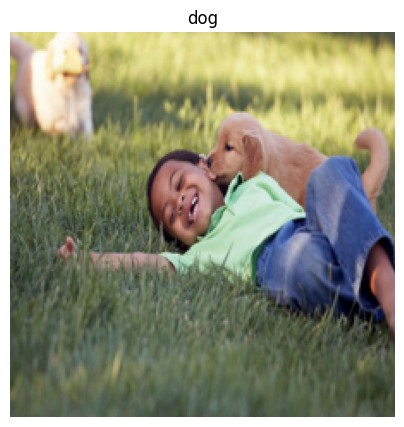

In [81]:
import PIL.Image as Image

_URL_ = 'https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F47%2F2021%2F06%2F16%2Fpuppy-kissing-boy-200493288-001-2000.jpg&q=60'

test_image = tf.keras.utils.get_file('test_image2.jpg', _URL_)
test_image = Image.open(test_image).resize((IMG_SHAPE, IMG_SHAPE))
test_image = np.array(test_image)/255.0
result = model.predict(test_image[np.newaxis, ...])
predicted_class = np.argmax(result[0], axis=-1)
plt.figure(figsize=(5, 5))
plt.imshow(test_image)
plt.axis('off')
plt.title(class_names[predicted_class])